## Using distil multilingual BERT

In [1]:
print('MomoxOkarun')

MomoxOkarun


In [2]:
!pip install tensorboard

In [4]:
import torch
from transformers import (
    DistilBertForMaskedLM,
    DistilBertTokenizerFast,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback,
    pipeline
)
from datasets import Dataset, load_dataset
import pandas as pd
import random
import numpy as np

In [6]:
# ========================
# 1. Configuration
# ========================
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
MODEL_NAME = "distilbert-base-multilingual-cased"
with open('/kaggle/input/finterms/financial_terms.txt') as f:
    FINANCIAL_TERMS = f.read().splitlines()

random.shuffle(FINANCIAL_TERMS)
MAX_SEQ_LENGTH = 256
TRAIN_RATIO = 0.85

In [7]:
# ========================
# 2. Helper Functions
# ========================
def check_and_add_tokens(tokenizer, terms):
    """Identify terms needing addition and update tokenizer"""
    terms_to_add = []
    for term in terms:
        tokens = tokenizer.tokenize(term)
        if len(tokens) > 1 or not tokenizer.convert_tokens_to_ids(term):
            terms_to_add.append(term)
    
    if terms_to_add:
        print(f"Adding {len(terms_to_add)} financial terms to tokenizer")
        tokenizer.add_tokens(terms_to_add)
    
    return tokenizer

def initialize_new_embeddings(model, tokenizer, new_terms):
    """Initialize new token embeddings with pre-trained averages"""
    with torch.no_grad():
        embeddings = model.get_input_embeddings().weight.data
        new_embeddings = embeddings[:-len(new_terms)].mean(dim=0)
        embeddings[-len(new_terms):] = new_embeddings


In [10]:
# ========================
# 3. Data Preparation
# ========================
# Load and clean data

gazetta_df = pd.read_csv("/kaggle/input/gazetta-financial-news-dataset/_--.csv")
rbk_df = pd.read_csv("/kaggle/input/rbk-financial-news-dataset/--.csv")
stockNews_df = pd.read_csv("/kaggle/input/stock-news-dataset/englishFinancialNews.csv")
print(f"Gazetta shape: {gazetta_df.shape}, RBK shape: {rbk_df.shape}, Stock News shape: {stockNews_df.shape}\n")
print("Gazetta info: \n", gazetta_df.info())
print("RBK info: \n", rbk_df.info())
print("Stock News info: \n", stockNews_df.info())

Gazetta shape: (10937, 7), RBK shape: (16517, 6), Stock News shape: (11606, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10937 entries, 0 to 10936
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10937 non-null  int64 
 1   text        10937 non-null  object
 2   summary     10937 non-null  object
 3   title       10937 non-null  object
 4   date        10937 non-null  object
 5   url         10937 non-null  object
 6   category    10937 non-null  object
dtypes: int64(1), object(6)
memory usage: 598.2+ KB
Gazetta info: 
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16517 entries, 0 to 16516
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16517 non-null  int64 
 1   url         16517 non-null  object
 2   date        16517 non-null  object
 3   title       16517 non-null  object
 4   category    16517 non-null

In [11]:
stockNews_df.rename(columns={"title":"text"}, inplace=True)
print(stockNews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11606 entries, 0 to 11605
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  11606 non-null  int64  
 1   Unnamed: 0    11606 non-null  float64
 2   text          11606 non-null  object 
 3   date          11605 non-null  object 
 4   stock         11605 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 453.5+ KB
None


In [19]:
df1_text = gazetta_df[['text']]
df2_text = rbk_df[['text']]
df3_text = stockNews_df[['text']]

# Concatenate the DataFrames along the rows
df = pd.concat([df1_text, df2_text, df3_text], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
print(df.info())

(39060, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39060 entries, 0 to 39059
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39060 non-null  object
dtypes: object(1)
memory usage: 305.3+ KB
None


In [20]:
df.head()

,text
0,В среду была опубликована финансовая отчетност...
1,Benzinga Pro Morning Price Check For Regional ...
2,Russia's Novak Says OPEC And Non-OPEC Countrie...
3,Федеральная резервная система (ФРС) США сохран...
4,Первый торговый день после пятничных санкций п...


In [21]:
dataset = Dataset.from_pandas(df[["text"]])

In [22]:
# ========================
# 4. Tokenization Setup
# ========================
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
#tokenizer = check_and_add_tokens(tokenizer, FINANCIAL_TERMS)

def tokenize_fn(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        return_special_tokens_mask=True  # Helps data collator
    )

tokenized_ds = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
split_ds = tokenized_ds.train_test_split(test_size=1-TRAIN_RATIO, seed=42)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/39060 [00:00<?, ? examples/s]

In [23]:
original_vocab_size = tokenizer.vocab_size  # ~120,000
#new_vocab_size = original_vocab_size + len(FINANCIAL_TERMS)

# Embedding layer shape before/after:
print(f"Original: {original_vocab_size} x 768")
#print(f"Updated: {new_vocab_size} x 768")

Original: 119547 x 768


In [29]:
# ========================
# 5. Model Initialization
# ========================
model = DistilBertForMaskedLM.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(len(tokenizer))

# Smart layer freezing: Unfreeze embeddings + last 3 layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze embeddings
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = True

# #Unfreeze last 1 transformer layer
# for layer in model.distilbert.transformer.layer[-1:]:
#     for param in layer.parameters():
#         param.requires_grad = True

         
# Define trainable components
trainable_components = [
    "transformer.layer.5",  # Last transformer layer (layer 5)
    "vocab_transform",       # MLM head components
    "vocab_layer_norm",
    "vocab_projector.bias"   # Only unfreeze the bias (weight may be tied)
]

# Unfreeze parameters matching the components
for name, param in model.named_parameters():
    if any(component in name for component in trainable_components):
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in model.named_parameters():
    print(f"{name} - Trainable: {param.requires_grad}")

# # Initialize new embeddings (if terms added)
# if len(FINANCIAL_TERMS) > 0:
#     initialize_new_embeddings(model, tokenizer, FINANCIAL_TERMS)

distilbert.embeddings.word_embeddings.weight - Trainable: False
distilbert.embeddings.position_embeddings.weight - Trainable: False
distilbert.embeddings.LayerNorm.weight - Trainable: False
distilbert.embeddings.LayerNorm.bias - Trainable: False
distilbert.transformer.layer.0.attention.q_lin.weight - Trainable: False
distilbert.transformer.layer.0.attention.q_lin.bias - Trainable: False
distilbert.transformer.layer.0.attention.k_lin.weight - Trainable: False
distilbert.transformer.layer.0.attention.k_lin.bias - Trainable: False
distilbert.transformer.layer.0.attention.v_lin.weight - Trainable: False
distilbert.transformer.layer.0.attention.v_lin.bias - Trainable: False
distilbert.transformer.layer.0.attention.out_lin.weight - Trainable: False
distilbert.transformer.layer.0.attention.out_lin.bias - Trainable: False
distilbert.transformer.layer.0.sa_layer_norm.weight - Trainable: False
distilbert.transformer.layer.0.sa_layer_norm.bias - Trainable: False
distilbert.transformer.layer.0.ffn

In [30]:
# ========================
# 6. Training Setup
# ========================
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
    pad_to_multiple_of=8  # Optimizes GPU utilization
)

training_args = TrainingArguments(
    output_dir="./finbert-mlm",
    logging_dir="./logs",
    num_train_epochs=5,
    per_device_train_batch_size=32,  # Reduced from 64
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=1,
    logging_steps=1,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,  # Better than fixed steps
    lr_scheduler_type="inverse_sqrt",
    gradient_accumulation_steps=2,
    fp16=True,
    report_to="tensorboard",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_ds["train"],
    eval_dataset=split_ds["test"],
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [26]:
# ========================
# 7. Baseline Model Evaluation
# ========================

# Initialize fresh model for baseline (don't freeze layers yet)
baseline_model = DistilBertForMaskedLM.from_pretrained(MODEL_NAME)
#baseline_model.resize_token_embeddings(len(tokenizer))  # Match tokenizer changes

# Evaluate baseline
trainer_baseline = Trainer(
    model=baseline_model,
    args=TrainingArguments(output_dir="./tmp", report_to="none"),
    data_collator=data_collator,
)
baseline_results = trainer_baseline.evaluate(eval_dataset=split_ds["test"])
baseline_perplexity = torch.exp(torch.tensor(baseline_results["eval_loss"])).item()
print(f"Baseline Perplexity (Pre-Fine-Tuning): {baseline_perplexity:.2f}")

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Baseline Perplexity (Pre-Fine-Tuning): 11.76


In [11]:
from transformers import pipeline
fill_mask = pipeline("fill-mask", model=baseline_model, tokenizer=tokenizer)
print(fill_mask("Revenue grew by [MASK]% this quarter."))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.03778262063860893, 'token': 10832, 'token_str': '80', 'sequence': 'Revenue grew by 80 % this quarter.'}, {'score': 0.0334482416510582, 'token': 11417, 'token_str': '75', 'sequence': 'Revenue grew by 75 % this quarter.'}, {'score': 0.03198811411857605, 'token': 10709, 'token_str': '60', 'sequence': 'Revenue grew by 60 % this quarter.'}, {'score': 0.0312785804271698, 'token': 11978, 'token_str': '95', 'sequence': 'Revenue grew by 95 % this quarter.'}, {'score': 0.02933659218251705, 'token': 10462, 'token_str': '50', 'sequence': 'Revenue grew by 50 % this quarter.'}]


In [12]:
fill_mask = pipeline("fill-mask", model=baseline_model, tokenizer=tokenizer)
print(fill_mask("\"Юнипро\" [MASK] выработку электроэнергии в 1 полугодии на 17,1%"))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.04431108012795448, 'token': 21351, 'token_str': 'начала', 'sequence': '" Юнипро " начала выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.04104795306921005, 'token': 30860, 'token_str': 'получила', 'sequence': '" Юнипро " получила выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.040997251868247986, 'token': 17127, 'token_str': 'составляет', 'sequence': '" Юнипро " составляет выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.03920186311006546, 'token': 118, 'token_str': '-', 'sequence': '" Юнипро " - выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.035053133964538574, 'token': 23137, 'token_str': 'начал', 'sequence': '" Юнипро " начал выработку электроэнергии в 1 полугодии на 17, 1 %'}]


In [13]:
# ========================
# 8. Training & Evaluation
# ========================
train_results = trainer.train()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Step,Training Loss,Validation Loss
1,3.078800,3.022720
2,2.992200,3.067851
3,3.366100,3.091392
4,3.054300,2.974847
5,3.322300,3.072196
6,3.054000,2.990547
7,3.096400,2.933193
8,2.996500,2.899940
9,3.062200,2.880604
10,2.982900,2.944720


There were missing keys in the checkpoint model loaded: ['vocab_projector.weight'].


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs --port 6006

In [14]:
torch.cuda.memory_allocated() * (1e-6)

1908.5701119999999

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [15]:
# Calculate final perplexity
eval_results = trainer.evaluate()
perplexity = torch.exp(torch.tensor(eval_results["eval_loss"])).item()
print(f"Final Perplexity: {perplexity:.2f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Final Perplexity: 10.82


In [ ]:
train_results.metrics

In [16]:
train_results.metrics["train_loss"]

2.605105547904968

In [ ]:
trainer.state.log_history[:2]

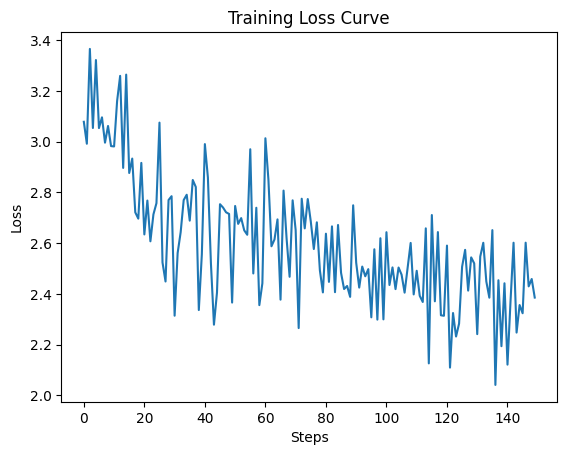

In [17]:
import matplotlib.pyplot as plt
# ========================
# 9. Monitoring (Optional)
# ========================
# Plot training loss
if trainer.state.log_history:
    train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
    plt.plot(train_loss)
    plt.title("Training Loss Curve")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    # Save the plot to a file
    plt.savefig("training_loss_curve.png")  # You can change the filename and format as needed
    plt.close()  # Close the plot to free up memory
else:
    print("No training loss data to plot!")

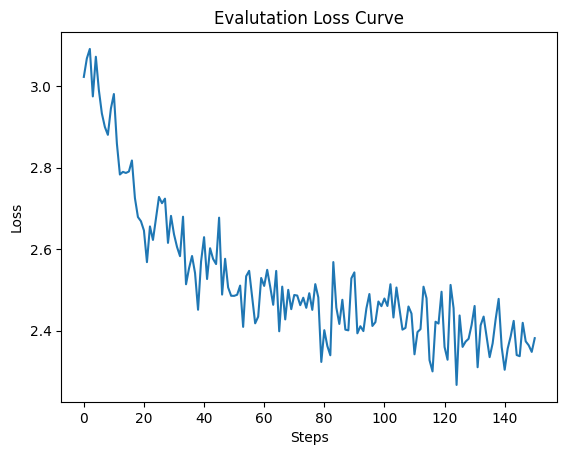

In [18]:
if trainer.state.log_history:
    train_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
    plt.plot(train_loss)
    plt.title("Evalutation Loss Curve")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.savefig("evalutation_loss_curve.png")  # You can change the filename and format as needed
    plt.close()  # Close the plot to free up memory
else:
    print("No training loss data to plot!")

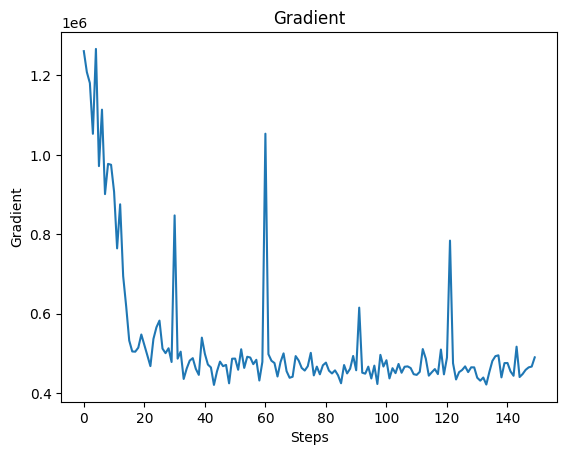

In [19]:
if trainer.state.log_history:
    train_loss = [log["grad_norm"] for log in trainer.state.log_history if "grad_norm" in log]
    plt.plot(train_loss)
    plt.title("Gradient")
    plt.xlabel("Steps")
    plt.ylabel("Gradient")
    plt.savefig("gradient_per_step_curve.png")  # You can change the filename and format as needed
    plt.close()  # Close the plot to free up memory
else:
    print("No training loss data to plot!")

In [20]:
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)
print(fill_mask("Revenue grew by [MASK]% this quarter."))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.04844597727060318, 'token': 10150, 'token_str': '10', 'sequence': 'Revenue grew by 10 % this quarter.'}, {'score': 0.038153618574142456, 'token': 10197, 'token_str': '20', 'sequence': 'Revenue grew by 20 % this quarter.'}, {'score': 0.0315052829682827, 'token': 10244, 'token_str': '30', 'sequence': 'Revenue grew by 30 % this quarter.'}, {'score': 0.027979161590337753, 'token': 10533, 'token_str': '40', 'sequence': 'Revenue grew by 40 % this quarter.'}, {'score': 0.02696882374584675, 'token': 10709, 'token_str': '60', 'sequence': 'Revenue grew by 60 % this quarter.'}]


In [21]:
print(fill_mask("\"Юнипро\" [MASK] выработку электроэнергии в 1 полугодии на 17,1%"))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.13244770467281342, 'token': 10234, 'token_str': 'за', 'sequence': '" Юнипро " за выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.09307624399662018, 'token': 118, 'token_str': '-', 'sequence': '" Юнипро " - выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.06674576550722122, 'token': 83788, 'token_str': 'составила', 'sequence': '" Юнипро " составила выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.05531777814030647, 'token': 67624, 'token_str': 'составил', 'sequence': '" Юнипро " составил выработку электроэнергии в 1 полугодии на 17, 1 %'}, {'score': 0.05328845977783203, 'token': 21351, 'token_str': 'начала', 'sequence': '" Юнипро " начала выработку электроэнергии в 1 полугодии на 17, 1 %'}]


In [22]:
print(tokenizer.tokenize("Юнипро увеличила выработку электроэнергии в 1 полугодии на 17,1%"))

['Ю', '##ни', '##про', 'у', '##вели', '##чила', 'вы', '##работку', 'электр', '##о', '##эн', '##ер', '##гии', 'в', '1', 'полу', '##годи', '##и', 'на', '17', ',', '1', '%']


In [23]:
print(tokenizer.tokenize("«Газпром» сообщил о росте объема поставок в Китай на 60%"))

['«', 'Газпром', '»', 'со', '##об', '##щил', 'о', 'рост', '##е', 'об', '##ъ', '##ема', 'поста', '##вок', 'в', 'Китай', 'на', '60', '%']


In [24]:
print(tokenizer.tokenize("Halliburton to End Several Contracts in Russia by Mid-May"))

['Hall', '##ibu', '##rton', 'to', 'End', 'Several', 'Contra', '##cts', 'in', 'Russia', 'by', 'Mid', '-', 'May']


In [25]:
fill_mask = pipeline("fill-mask", model=baseline_model, tokenizer=tokenizer)
print(fill_mask("Halliburton to [MASK] Several Contracts in Russia by Mid-May"))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.07605136185884476, 'token': 14962, 'token_str': 'How', 'sequence': 'Halliburton to How Several Contracts in Russia by Mid - May'}, {'score': 0.03891952708363533, 'token': 33623, 'token_str': 'establish', 'sequence': 'Halliburton to establish Several Contracts in Russia by Mid - May'}, {'score': 0.017358412966132164, 'token': 34307, 'token_str': 'operate', 'sequence': 'Halliburton to operate Several Contracts in Russia by Mid - May'}, {'score': 0.016276687383651733, 'token': 13924, 'token_str': 'See', 'sequence': 'Halliburton to See Several Contracts in Russia by Mid - May'}, {'score': 0.011806516908109188, 'token': 26756, 'token_str': 'reçoit', 'sequence': 'Halliburton to reçoit Several Contracts in Russia by Mid - May'}]


In [26]:
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)
print(fill_mask("Halliburton to [MASK] Several Contracts in Russia by Mid-May"))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'score': 0.06265132874250412, 'token': 14962, 'token_str': 'How', 'sequence': 'Halliburton to How Several Contracts in Russia by Mid - May'}, {'score': 0.02820052020251751, 'token': 15074, 'token_str': 'Report', 'sequence': 'Halliburton to Report Several Contracts in Russia by Mid - May'}, {'score': 0.02302178554236889, 'token': 33623, 'token_str': 'establish', 'sequence': 'Halliburton to establish Several Contracts in Russia by Mid - May'}, {'score': 0.016962844878435135, 'token': 11791, 'token_str': 'Do', 'sequence': 'Halliburton to Do Several Contracts in Russia by Mid - May'}, {'score': 0.015569002367556095, 'token': 25641, 'token_str': 'Work', 'sequence': 'Halliburton to Work Several Contracts in Russia by Mid - May'}]


In [27]:
trainer.save_model("./finbert-mlm/finetuned_v2")
tokenizer.save_pretrained("./finbert-mlm/finetuned_v2")

('./finbert-mlm/finetuned_v1/tokenizer_config.json',
 './finbert-mlm/finetuned_v1/special_tokens_map.json',
 './finbert-mlm/finetuned_v1/vocab.txt',
 './finbert-mlm/finetuned_v1/added_tokens.json',
 './finbert-mlm/finetuned_v1/tokenizer.json')